# 6. Análisis de Componentes Principales (ACP)
### Por: David Alonso Rueda Rodríguez

### Objetivo:
- Transformar la función de la fuente encontrada de la versión python2.0 a Python 3.0

#### Esta actividad requiere la ejecución de las siguentes librerías:

- gdal
- numpy
- glob

## Fuente Original:
https://github.com/grgeosteve/PCA/tree/master/PrincipalComponents

In [56]:
import glob
import numpy as np
from osgeo import gdal
import rasterio as ras
from earthpy import plot as ep

In [59]:
#
# Desarrollo de función para estimación de componentes principales
def pca(input_image, output_image, outPCBands):
    """
    Nombre Función: pca
    
    Objetivo de la Función:
        - Generar archivo TIF y archivo con estadísticas asociadas
        
    Parámetros de entrada:
    
        input_image = ruta de la imagen de entrada
        output_image = ruta de imagen de salida
        outPCBands = Número de componentes principales de salida
    
    Versiones:
    
    000 - Edición y transformación de la función pca desde
        Python 2.0 y archivos asociados PyQt 4.0 a versión
        Python 3.0
    
    Fuente original: https://github.com/grgeosteve/PCA/blob/master/PrincipalComponents/pca.py
    
    """
    import numpy as np
    from osgeo import gdal
    gdal.AllRegister()
    
    dataset = gdal.Open(input_image)
    bandNumber = dataset.RasterCount
    bandMean = np.empty(bandNumber)

    for i in range(bandNumber):
        band = dataset.GetRasterBand(i+1).ReadAsArray(0,0,dataset.RasterXSize, dataset.RasterYSize)
        bandMean[i] = np.amin(band, axis=None)

    corrMatrix = np.empty((bandNumber, bandNumber))

    for i in range(bandNumber):
        band = dataset.GetRasterBand(i+1)
        bandArray = band.ReadAsArray(0, 0,dataset.RasterXSize,dataset.RasterYSize).astype(np.float).flatten()
        bandArray = bandArray - bandMean[i]
        corrMatrix[i][i] = np.corrcoef(bandArray, bandArray)[0][1]
    
    band = None
    bandArray = None
    
    for i in range(1, bandNumber+1):
        band1 = dataset.GetRasterBand(i)
        bandArray1 = band1.ReadAsArray(0,0, dataset.RasterXSize, dataset.RasterYSize).astype(np.float).flatten()
        bandArray1 = bandArray1 - bandMean[i-1]
        for j in range(i+1, bandNumber + 1):
            band2 = dataset.GetRasterBand(j)
            bandArray2 = band2.ReadAsArray(0,0,dataset.RasterXSize, dataset.RasterYSize).astype(np.float).flatten()
            bandArray2 = bandArray2 - bandMean[j-1]
            corrMatrix[j - 1][i - 1] = corrMatrix[i - 1][j - 1] = np.corrcoef(bandArray1, bandArray2)[0][1]

    eigenvals, eigenvectors = np.linalg.eig(corrMatrix)

    indexLookupTable = [i for i in range(bandNumber)]

    for i in range(bandNumber):
            for j in range(bandNumber - 1, i, -1):
                if eigenvals[indexLookupTable[j]] > eigenvals[indexLookupTable[j - 1]]:
                    temp = indexLookupTable[j]
                    indexLookupTable[j] = indexLookupTable[j - 1]
                    indexLookupTable[j - 1] = temp
    
    driver = gdal.GetDriverByName("GTiff")
    outDataset  = driver.Create(outputRasterFileName, dataset.RasterXSize, dataset.RasterYSize, outPCBands, gdal.GDT_CFloat32)

    for i in range(outPCBands):
        pc = 0
        for j in range(bandNumber):
            band = dataset.GetRasterBand(j + 1)
            bandAdjustArray = band.ReadAsArray(0, 0, dataset.RasterXSize, dataset.RasterYSize).astype(np.float) - bandMean[j]
            pc = pc + eigenvectors[j, indexLookupTable[i]] * bandAdjustArray
        pcband = outDataset.GetRasterBand(i + 1)
        pcband.WriteArray(pc)

    if dataset.GetGeoTransform() != None:
        outDataset.SetGeoTransform(dataset.GetGeoTransform())

    if dataset.GetProjection() != None:
        outDataset.SetProjection(dataset.GetProjection())

    corrBandBand = [['' for i in range(bandNumber + 1)] for j in range(bandNumber + 1)]
    corrBandBand[0][0] = "Correlation Matrix:\n"
    for j in range(1, 1 + bandNumber):
        header = 'Band' + str(j) + '\t'
        corrBandBand[0][j] = header
    for i in range(1, 1 + bandNumber):
        vertical = 'Band' + str(i)
        corrBandBand[i][0] = vertical
        for i in range(1, 1 + bandNumber):
            for j in range(1, 1 + bandNumber):
                corrBandBand[i][j] = "%.3f \t" % corrMatrix[i - 1, j - 1]

    covBandPC = [['' for i in range(bandNumber + 1)] for j in range(bandNumber + 1)]
    covBandPC[0][0] = "Cov.Eigenvectors:\n"
    for j in range(1, 1 + bandNumber):
        header = 'PC' + str(j) + '\t'
        covBandPC[0][j] = header
    for i in range(1, 1 + bandNumber):
        vertical = "Band" + str(i)
        covBandPC[i][0] = vertical
    for i in range(1, 1 + bandNumber):
        for j in range(1, 1 + bandNumber):
            covBandPC[i][j] = "%.3f \t" % eigenvectors[i - 1, indexLookupTable[j - 1]]

    covEigenvalMat = [['' for i in range(bandNumber + 1)] for j in range(5)]
    covEigenvalMat[0][0] = "Bands:\n           \t"
    covEigenvalMat[1][0] = "Cov.Eigenvalues:"
    covEigenvalMat[2][0] = "Sum of Eigenvalues:"
    covEigenvalMat[3][0] = "Eigenvalues/Sum:   "
    covEigenvalMat[4][0] = "Percentages(%):    "

    eigvalSum = 0.0
    sum = np.sum(eigenvals)
    for i in range(bandNumber):
        covEigenvalMat[0][i + 1] = "PC" + str(i + 1) + '\t'
        covEigenvalMat[1][i + 1] = "%.3f \t" % eigenvals[indexLookupTable[i]]
        eigvalSum = eigvalSum + eigenvals[indexLookupTable[i]]
        covEigenvalMat[2][i + 1] = "%.3f \t" % eigvalSum
        covEigenvalMat[3][i + 1] = "%.3f \t" % (eigvalSum / sum)
        covEigenvalMat[4][i + 1] = "%.1f \t" % (eigvalSum / sum * 100.0)

    statText = ""
    statFileName = outputRasterFileName.split('.')[0] + "_statistics.txt"
    statFile = open(statFileName, "w")

    for i in range(len(corrBandBand)):
        for j in range(len(corrBandBand)): # symmetrical matrix
            statText = statText + corrBandBand[i][j]
            if (j < len(corrBandBand[0]) - 1):
                statText = statText + "\t"
        statText = statText + "\n"

    statText = statText + "\n"

    for i in range(len(covBandPC)):
        for j in range(len(covBandPC[0])):
            statText = statText + covBandPC[i][j]
            if (j < len(covBandPC[0]) - 1):
                statText = statText + "\t"
        statText = statText + "\n"

    statText = statText + "\n"

    for i in range(len(covEigenvalMat)):
        for j in range(len(covEigenvalMat[0])):
            statText = statText + covEigenvalMat[i][j]
            if (j < len(covEigenvalMat[0]) - 1):
                statText = statText + "\t"
        statText = statText + "\n"

    statFile.write(statText)
    statFile.close()
    dataset = None
    outDataset = None

## Trabajo con archivos Sentinel

In [60]:
sentinel_url = 'src/Sentinel/earthpy/Sentinel_AOI2.jp2'
outputRasterFileName = 'src/Sentinel/earthpy/Sentinel_PCA.tif'
outPCBands = 1
# Ejecución de la función desarrollada
pca(sentinel_url,outputRasterFileName,1)

#### Visualización del archivo Sentinel con ACP

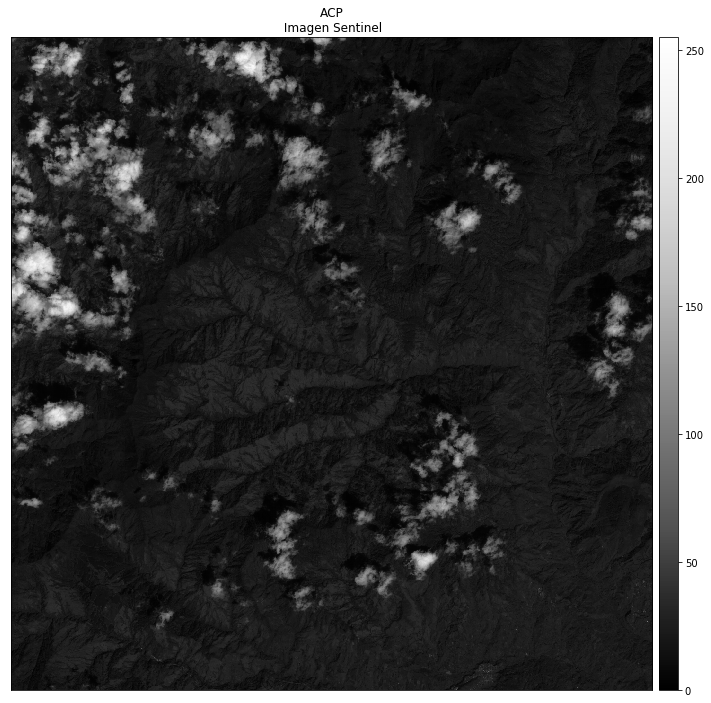

In [58]:
title="ACP\n Imagen Sentinel"
img = ras.open(outputRasterFileName)
ep.plot_bands(img.read(), title=title, cbar=True)

## Trabajo con archivos Landsat

In [62]:
landsat_url = 'src/Landsat/earthpy/Landsat_AOI.tif'
outputRasterFileNameLandsat = 'src/Landsat/earthpy/Landsat_PCA.tif'
outPCBands = 1
# Ejecución de la función desarrollada
pca(landsat_url,outputRasterFileName,1)

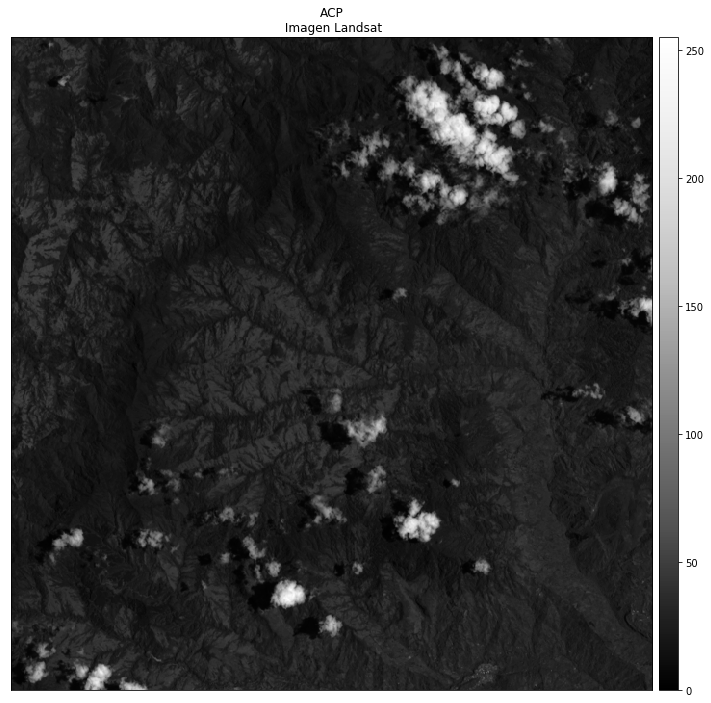

In [63]:
title="ACP\n Imagen Landsat"
img = ras.open(outputRasterFileNameLandsat)
ep.plot_bands(img.read(), title=title, cbar=True)